<a href="https://colab.research.google.com/github/EllieZhangy/Artwork-Classification-and-Style-Transfer/blob/main/Style_Transfer_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artwork Classification and Style Transfer
## Task2: Style Transfer (Transfer Learning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import os
from PIL import Image
import os

## 1.Data Load

In [ ]:
content_image_path='/content/drive/MyDrive/Colab Notebooks/DL/final project/Vincent_van_Gogh/Vincent_van_Gogh_84.jpg'
style_image_path='/content/drive/MyDrive/Colab Notebooks/DL/final project/Style Pictures/Francisco_Goya_100.jpg'

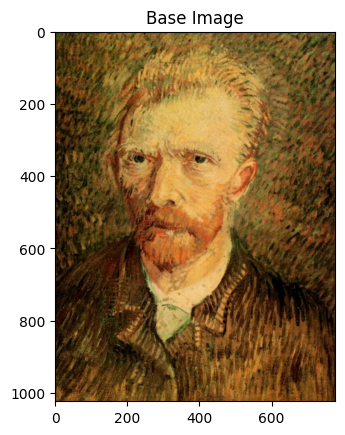

In [ ]:
plt.figure()
plt.title("Base Image")
img1 = load_img(content_image_path)
plt.imshow(img1)

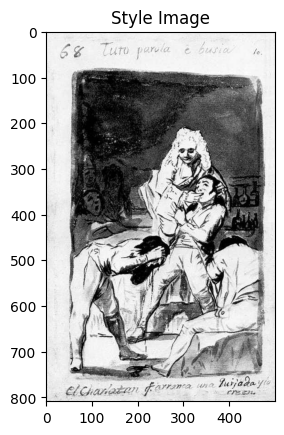

In [ ]:
plt.figure()
plt.title("Style Image")
img1 = load_img(style_image_path)
plt.imshow(img1)

## 2.Define Function

In [ ]:
size=360

In [ ]:
def read_img(path):
    img=tf.keras.preprocessing.image.load_img(path,target_size=(size,size))
    img=tf.keras.preprocessing.image.img_to_array(img,dtype='uint8')
    img=np.expand_dims(img,axis=0)
    return img

In [ ]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [ ]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## 3.Model1: Transfer Learning based on VGG19

### 2.1 Model Architecture

In [ ]:
model=VGG19(include_top=False,input_shape=(size,size,3))
model.trainable=False
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 360, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 360, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 180, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 180, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 180, 128)     147584    
                                                              

In [ ]:
content_layer='block3_conv4'
content_model=Model(inputs=model.input,outputs=model.get_layer(content_layer).output)

In [ ]:
style_layers=[ 'block1_conv1', 'block2_conv2','block3_conv3', 'block4_conv4','block5_conv2']
style_models=[Model(inputs=model.input,outputs=model.get_layer(style_layer).output) for style_layer in style_layers]

In [ ]:
# define gram_matrix, content_cost and style_cost
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost =  tf.reduce_mean(tf.square(generated_img-content_img))
    return cost
def style_cost(style_img, generated_img, style_layer_wts):  # <- Add the argument here
    total_cost = 0

    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS-GG))
        total_cost += current_cost
    return total_cost

### 2.2 Generate the Styled Image

In [ ]:
def generate(content_image_path, style_image_path, lr, iterations, style_wt, content_wt, style_layer_wts):
    content_image_preprocessed = preprocess_image(content_image_path)
    style_image_preprocessed = preprocess_image(style_image_path)
    generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

    generated_images = []
    costs = []

    min_cost = 1 * 10 ** 12
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
            J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image, style_layer_wts=style_layer_wts)
            J_total = content_wt * J_content + style_wt * J_style

        gradients = tape.gradient(J_total, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])

        costs.append(J_total.numpy())
        generated_images.append(generated_image.numpy())

        if i % 50 == 0:
            print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i + 1, iterations, J_total, J_style, J_content))

    return generated_images, costs

### 2.3 Hyper-Parameter Selectioin

In [ ]:
import numpy as np

# Parameters for Random Search
search_iterations = 10  # Set to 10 iterations for random search
iterations = 250

best_cost = float('inf')  # Initialize the best cost as infinity
best_params = None  # Initialize the best parameters

for _ in range(search_iterations):
    # Randomly select hyperparameters
    lr_random = 10 ** np.random.uniform(-3, 1)  # Randomly choose learning rate between 0.001 and 10
    style_wt_random = 10 ** np.random.uniform(-2, 1)  # Randomly choose style weight between 0.01 and 10
    content_wt_random = 10 ** np.random.uniform(-2, 1)  # Randomly choose content weight between 0.01 and 10
    style_layer_wts_random = [10 ** np.random.uniform(-2, 1) for _ in style_layers]  # Randomly choose style layer weights

    print(f"Testing with lr={lr_random:.4f}, style_wt={style_wt_random:.4f}, content_wt={content_wt_random:.4f}, style_layer_wts={style_layer_wts_random}")

    # Run style transfer with the randomly chosen hyperparameters
    generated_images, costs = generate(content_image_path, style_image_path, lr_random, iterations, style_wt_random, content_wt_random, style_layer_wts_random)

    final_cost = costs[-1]
    if final_cost < best_cost:
        best_cost = final_cost
        best_params = {
            "lr": lr_random,
            "style_wt": style_wt_random,
            "content_wt": content_wt_random,
            "style_layer_wts": style_layer_wts_random
        }

print(f"Best parameters after Random Search: {best_params}")

Testing with lr=0.6382, style_wt=0.0153, content_wt=0.0769, style_layer_wts=[1.0052109618379286, 7.914834341091855, 0.09368250693095884, 0.08292486640935334, 0.013427826401573847]
Iteration:1/250, Total Cost:1.2194086463209472e+17, Style Cost: 7.964575259074494e+18, Content Cost: 0.0
Iteration:51/250, Total Cost:3.2886676254621696e+16, Style Cost: 2.1479953332237763e+18, Content Cost: 296.0294494628906
Iteration:101/250, Total Cost:2.069097488370893e+16, Style Cost: 1.351432281687851e+18, Content Cost: 575.0222778320312
Iteration:151/250, Total Cost:1.45641804136448e+16, Style Cost: 9.512603518343578e+17, Content Cost: 913.4915161132812
Iteration:201/250, Total Cost:1.0800089329041408e+16, Style Cost: 7.054085210714931e+17, Content Cost: 1272.803466796875
Testing with lr=0.0312, style_wt=0.1384, content_wt=0.2614, style_layer_wts=[0.46390748470180226, 4.572772339911842, 9.309211188840433, 0.020457663164735903, 2.761283602963592]
Iteration:1/250, Total Cost:2.3324242525709926e+18, Style

In [ ]:
# Using the best parameters obtained from Random Search
best_lr = best_params["lr"]
best_style_wt = best_params["style_wt"]
best_content_wt = best_params["content_wt"]
best_style_layer_wts = best_params["style_layer_wts"]

# Generate an image with the best parameters
generated_images_best, costs_best1 = generate(content_image_path, style_image_path, best_lr, iterations, best_style_wt, best_content_wt, best_style_layer_wts)
best_generated_image = Image.fromarray(deprocess(generated_images_best[-1][0]))

Iteration:1/250, Total Cost:1.3140071049016115e+17, Style Cost: 3.6047409002043146e+18, Content Cost: 0.0
Iteration:51/250, Total Cost:1.740537107316736e+16, Style Cost: 4.7748488023454515e+17, Content Cost: 988.828125
Iteration:101/250, Total Cost:7940889871646720.0, Style Cost: 2.178439538886574e+17, Content Cost: 2045.7496337890625
Iteration:151/250, Total Cost:4050047322816512.0, Style Cost: 1.1110572729617613e+17, Content Cost: 2945.8759765625
Iteration:201/250, Total Cost:2488471570612224.0, Style Cost: 6.826671846352486e+16, Content Cost: 3527.548583984375


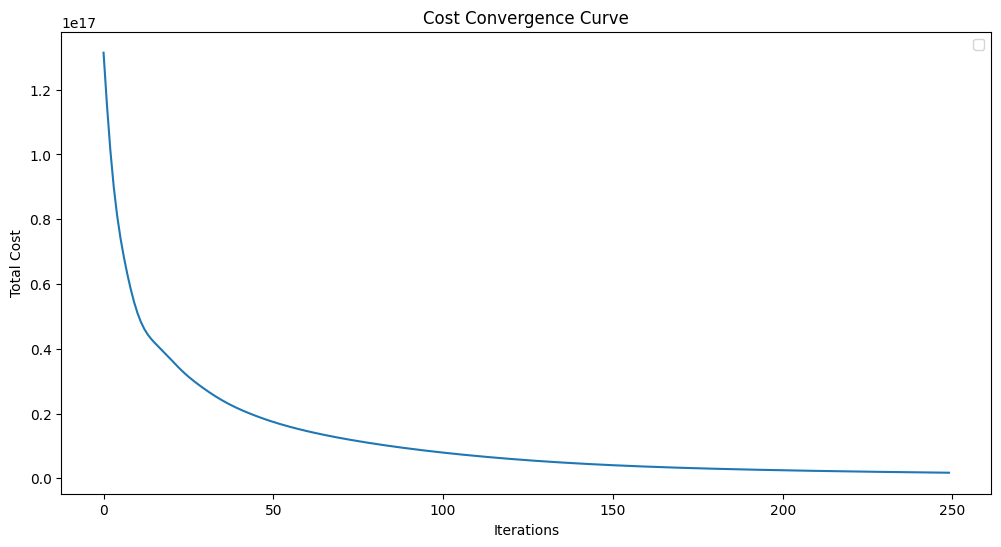

In [ ]:
# Plot the Costs Over Iterations
plt.figure(figsize=(12,6))
plt.plot(costs_best1)
plt.xlabel('Iterations')
plt.ylabel('Total Cost')
plt.title('Cost Convergence Curve')
plt.legend()
plt.show()

In [ ]:
print(costs_best1[-1])

1732020200000000.0


In [ ]:
model_dir = '/content/drive/MyDrive/DL_Final/Models/'
model.save(model_dir +'style_transfer_vgg19.h5')

"\nmodel_dir = '/content/drive/MyDrive/DL_Final/Models/'\nmodel.save(model_dir +'style_transfer_vgg19.h5')\n"

### 2.4 Result Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

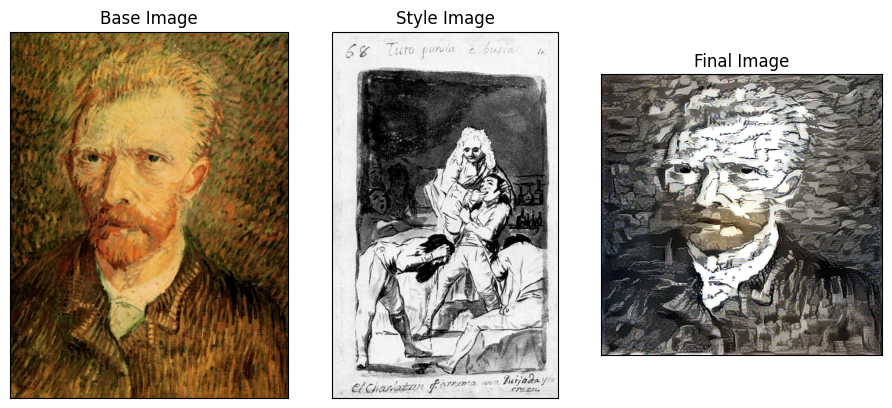

In [ ]:
plt.figure(figsize=(12,8))
dict_title={1:"Base Image",2:"Style Image",3:"Final Image"}
images={1:tf.keras.preprocessing.image.load_img(content_image_path),2:tf.keras.preprocessing.image.load_img(style_image_path), 3:best_generated_image}
for i in range(1,4):
    plt.subplot(2,4,i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(dict_title[i])
plt.savefig('out_VGG19.png')
plt.show

## 3.Model2: Transfer Learning based on ResNet

### 3.1 Model Architecture

In [ ]:
from tensorflow.keras.applications import ResNet50

model = ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3))
model.trainable = False
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 360, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 366, 366, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 180, 180, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
content_layer = 'conv3_block4_out'
content_model = Model(inputs=model.input, outputs=model.get_layer(content_layer).output)

style_layers = [
    'conv1_relu',
    'conv2_block3_out',
    'conv3_block4_out',
    'conv4_block6_out',
    'conv5_block3_out'
]
style_models = [Model(inputs=model.input, outputs=model.get_layer(style_layer).output) for style_layer in style_layers]


### 3.2 Model Traning

In [ ]:
import numpy as np

# Parameters for Random Search
search_iterations = 10  # Set to 10 iterations for random search
iterations = 250

best_cost = float('inf')  # Initialize the best cost as infinity
best_params = None  # Initialize the best parameters

for _ in range(search_iterations):
    # Randomly select hyperparameters
    lr_random = 10 ** np.random.uniform(-3, 1)  # Randomly choose learning rate between 0.001 and 10
    style_wt_random = 10 ** np.random.uniform(-2, 1)  # Randomly choose style weight between 0.01 and 10
    content_wt_random = 10 ** np.random.uniform(-2, 1)  # Randomly choose content weight between 0.01 and 10
    style_layer_wts_random = [10 ** np.random.uniform(-2, 1) for _ in style_layers]  # Randomly choose style layer weights

    print(f"Testing with lr={lr_random:.4f}, style_wt={style_wt_random:.4f}, content_wt={content_wt_random:.4f}, style_layer_wts={style_layer_wts_random}")

    # Run style transfer with the randomly chosen hyperparameters
    generated_images, costs = generate(content_image_path, style_image_path, lr_random, iterations, style_wt_random, content_wt_random, style_layer_wts_random)

    final_cost = costs[-1]
    if final_cost < best_cost:
        best_cost = final_cost
        best_params = {
            "lr": lr_random,
            "style_wt": style_wt_random,
            "content_wt": content_wt_random,
            "style_layer_wts": style_layer_wts_random
        }

print(f"Best parameters after Random Search: {best_params}")

Testing with lr=0.0047, style_wt=1.3364, content_wt=7.0765, style_layer_wts=[6.752652937594013, 0.025779456567160554, 0.01195983198954773, 6.865966567000513, 0.03789101829828926]
Iteration:1/250, Total Cost:63722930176.0, Style Cost: 47682121728.0, Content Cost: 0.0
Iteration:51/250, Total Cost:63453691904.0, Style Cost: 47480659968.0, Content Cost: 0.05535136163234711
Iteration:101/250, Total Cost:63185674240.0, Style Cost: 47280107520.0, Content Cost: 0.22086669504642487
Iteration:151/250, Total Cost:62918934528.0, Style Cost: 47080513536.0, Content Cost: 0.4957575500011444
Iteration:201/250, Total Cost:62653464576.0, Style Cost: 46881869824.0, Content Cost: 0.8792210221290588
Testing with lr=0.0050, style_wt=4.6531, content_wt=5.0528, style_layer_wts=[0.020942769251013155, 0.20740874931990644, 0.010699495431084415, 0.30794414536329295, 0.5624783776835427]
Iteration:1/250, Total Cost:738467264.0, Style Cost: 158705520.0, Content Cost: 0.0
Iteration:51/250, Total Cost:734918016.0, Sty

In [ ]:
# Using the best parameters obtained from Random Search
best_lr = best_params["lr"]
best_style_wt = best_params["style_wt"]
best_content_wt = best_params["content_wt"]
best_style_layer_wts = best_params["style_layer_wts"]

# Generate an image with the best parameters
generated_images_best, costs_best2 = generate(content_image_path, style_image_path, best_lr, iterations, best_style_wt, best_content_wt, best_style_layer_wts)
best_generated_image = Image.fromarray(deprocess(generated_images_best[-1][0]))

Iteration:1/250, Total Cost:35755380.0, Style Cost: 595296192.0, Content Cost: 0.0
Iteration:51/250, Total Cost:7903355.5, Style Cost: 131582888.0, Content Cost: 3299.711181640625
Iteration:101/250, Total Cost:1861832.875, Style Cost: 30995460.0, Content Cost: 6959.10205078125
Iteration:151/250, Total Cost:804721.8125, Style Cost: 13394903.0, Content Cost: 8581.9248046875
Iteration:201/250, Total Cost:443992.96875, Style Cost: 7388891.0, Content Cost: 9117.388671875


### 3.3 Result Analysis

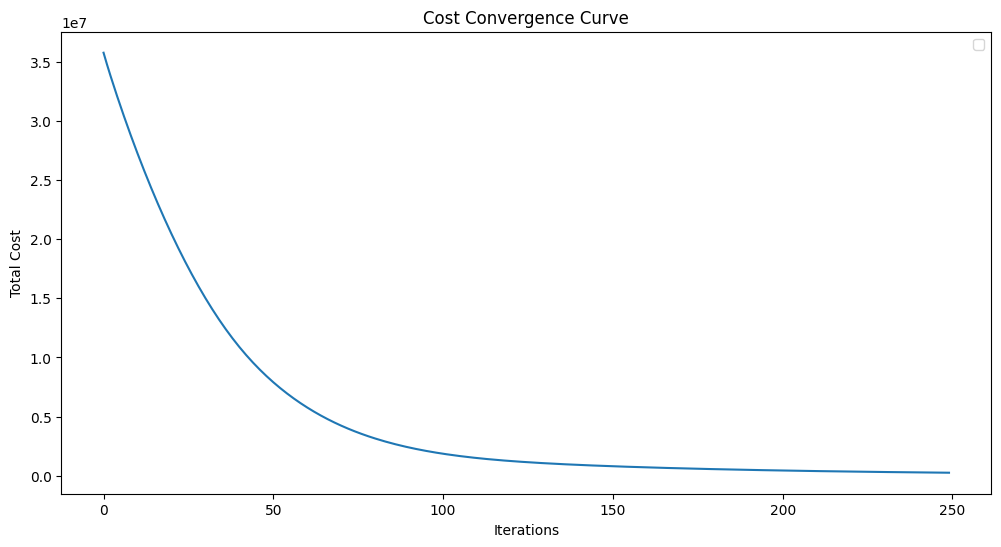

In [ ]:
# Plot the Costs Over Iterations
plt.figure(figsize=(12,6))
plt.plot(costs_best2)
plt.xlabel('Iterations')
plt.ylabel('Total Cost')
plt.title('Cost Convergence Curve')
plt.legend()
plt.show()

In [ ]:
print(costs_best2[-1])

257624.42


<function matplotlib.pyplot.show(close=None, block=None)>

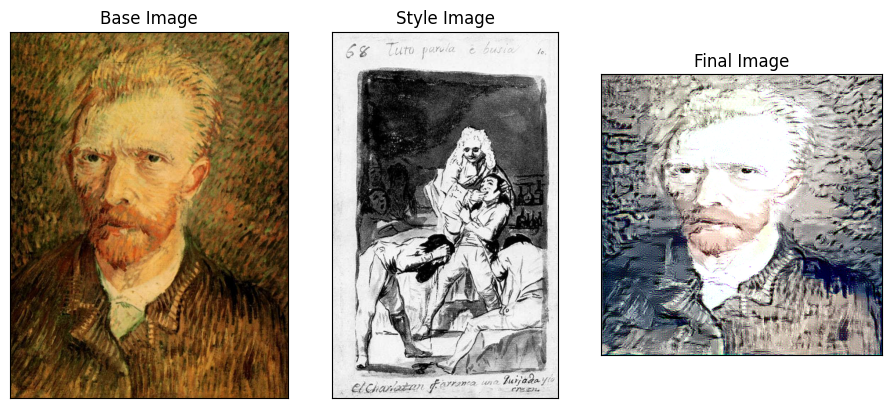

In [ ]:
plt.figure(figsize=(12,8))
dict_title={1:"Base Image",2:"Style Image",3:"Final Image"}
images={1:tf.keras.preprocessing.image.load_img(content_image_path),2:tf.keras.preprocessing.image.load_img(style_image_path), 3:best_generated_image}
for i in range(1,4):
    plt.subplot(2,4,i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(dict_title[i])
plt.savefig('out_ResNet.png')
plt.show

In [ ]:
model_dir = '/content/drive/MyDrive/DL_Final/Models/'
model.save(model_dir +'style_transfer_resnet.h5')